
🟢 Steps Detected: 1299
🚶 Distance Walked: 1013.22 meters (1.01 km)
🔥 Calories Burned: 46.41 kcal
🕒 Duration: 10.82 minutes


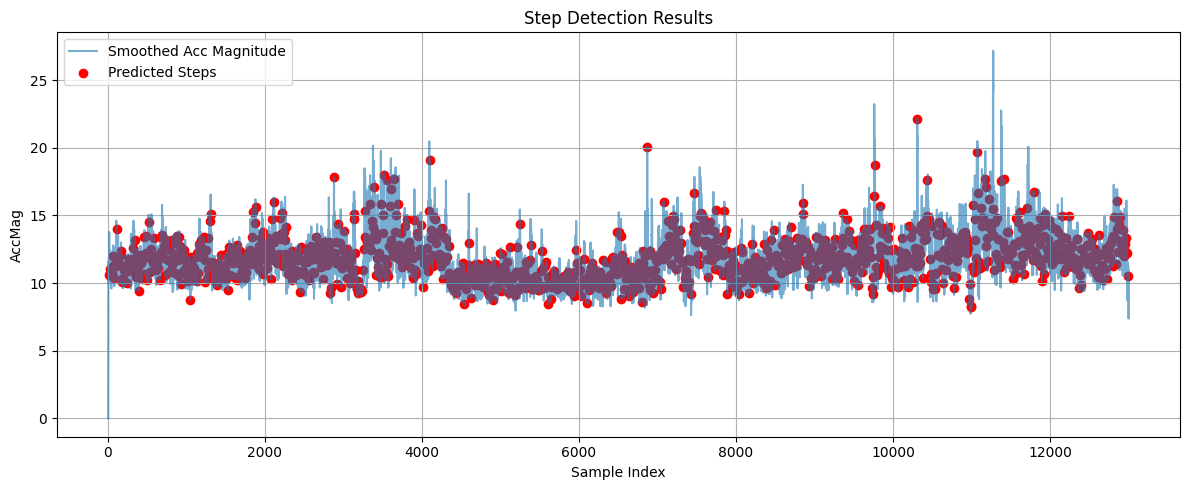

In [8]:
## The issue with this model is when a person walks on a incline or a decline path the caloric count cannot be accurate as a person burns
##more calorins while walking on a incline path and the estimated caloric count will be according to a straight path 
import pandas as pd
import numpy as np
import joblib
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Load the saved model and scaler
model = joblib.load('step_detector_model.pkl')
scaler = joblib.load('scaler.pkl')

# Load new IMU data (replace with actual file)
df = pd.read_csv("HIMU2.csv", skiprows=3)
df.columns = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ']

# Preprocess
df['AccMag'] = np.sqrt(df['AccX']**2 + df['AccY']**2 + df['AccZ']**2)
df['GyroMag'] = np.sqrt(df['GyroX']**2 + df['GyroY']**2 + df['GyroZ']**2)
df['AccMag_Smooth'] = df['AccMag'].rolling(window=5).mean().fillna(0)

# ---- Feature Extraction Function ----
def extract_features(df, window_size=20, step_size=10):
    X, indices = [], []
    for start in range(0, len(df) - window_size, step_size):
        end = start + window_size
        window = df.iloc[start:end]
        
        features = []
        for col in ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'AccMag', 'GyroMag']:
            features.extend([
                window[col].mean(),
                window[col].std(),
                window[col].min(),
                window[col].max()
            ])
        X.append(features)
        indices.append(start + window_size // 2)  # index to plot on mid of window
    return np.array(X), indices

# Extract and scale features
X_new, indices = extract_features(df)
X_new_scaled = scaler.transform(X_new)

# Predict using trained model
predictions = model.predict(X_new_scaled)

# ---- Step Count and Summary ----
step_windows = np.where(predictions == 1)[0]
step_count = len(step_windows)

# Distance estimation
step_length_m = 0.78  # average adult step length in meters
distance_m = step_count * step_length_m
distance_km = distance_m / 1000

# Calories burned estimation
weight_kg = 70  # adjust as needed
MET = 3.5  # Moderate walking
duration_minutes = (step_count * 0.5) / 60  # 0.5s per step assumption
calories = MET * weight_kg * duration_minutes * 0.0175

# ---- Print Results ----
print(f"\n🟢 Steps Detected: {step_count}")
print(f"🚶 Distance Walked: {distance_m:.2f} meters ({distance_km:.2f} km)")
print(f"🔥 Calories Burned: {calories:.2f} kcal")
print(f"🕒 Duration: {duration_minutes:.2f} minutes")

# ---- Optional Plot ----
plt.figure(figsize=(12, 5))
plt.plot(df['AccMag_Smooth'].values, label='Smoothed Acc Magnitude', alpha=0.6)
plt.scatter(
    [indices[i] for i in step_windows],
    df['AccMag_Smooth'].iloc[[indices[i] for i in step_windows]],
    color='red', label='Predicted Steps'
)
plt.title(f"Step Detection Results")
plt.xlabel("Sample Index")
plt.ylabel("AccMag")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
